### Training Configurations:

- For PTI to run successfull, you need to adapt all the config files in `configs/` of the PTI Repo

In [1]:
import os
from PIL import Image

In [2]:
os.chdir('../../PTI/')

In [3]:
# from scripts.run_pti import run_PTI
# run_PTI(run_name='test', use_wandb=False, use_multi_id_training=False)

### Evaluation

In [4]:
import torch
# Initalize original custom SG2-Ada generator
import pickle
os.chdir('../stylegan2-ada-pytorch/')
model_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/Stylegan2_Ada/Experiments/00003-stylegan2_ada_images-mirror-auto2-kimg1000-resumeffhq512/network-snapshot-000920.pkl"
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    G = architecture['G_ema'].to('cuda')  # torch.nn.Module 
    D = architecture['D'].to('cuda')

In [5]:
from glob import glob
import matplotlib.pyplot as plt
model_paths = glob("/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/PTI/experiments/checkpoints/*.pt")
e4e_images_paths = glob("/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Zalando_Germany_Dataset/dresses/images/e4e_images/*/*.jpg")

In [6]:
def compare_outputs(path):

    # Load PTI finetuned model
    G_PTI = torch.load(path)

    # Load corresponding latent embedding
    sku = path.split('/')[-1].split('_')[-1].split('.')[0]
    latent = torch.load(f"/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/PTI/experiments/embeddings/zalando_germany/PTI/{sku}/0.pt")

    #  Create image from finetuned-PTI model
    img = G_PTI.synthesis(latent)
    img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img_pti = Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')

    #  Create image from original SG2-Ada model
    img = G.synthesis(latent)
    img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img_sg2 = Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')

    # Load Original
    orig_path = [elem for elem in e4e_images_paths if sku in elem][0]
    img_orig = Image.open(orig_path)


    return img_pti, img_sg2, img_orig

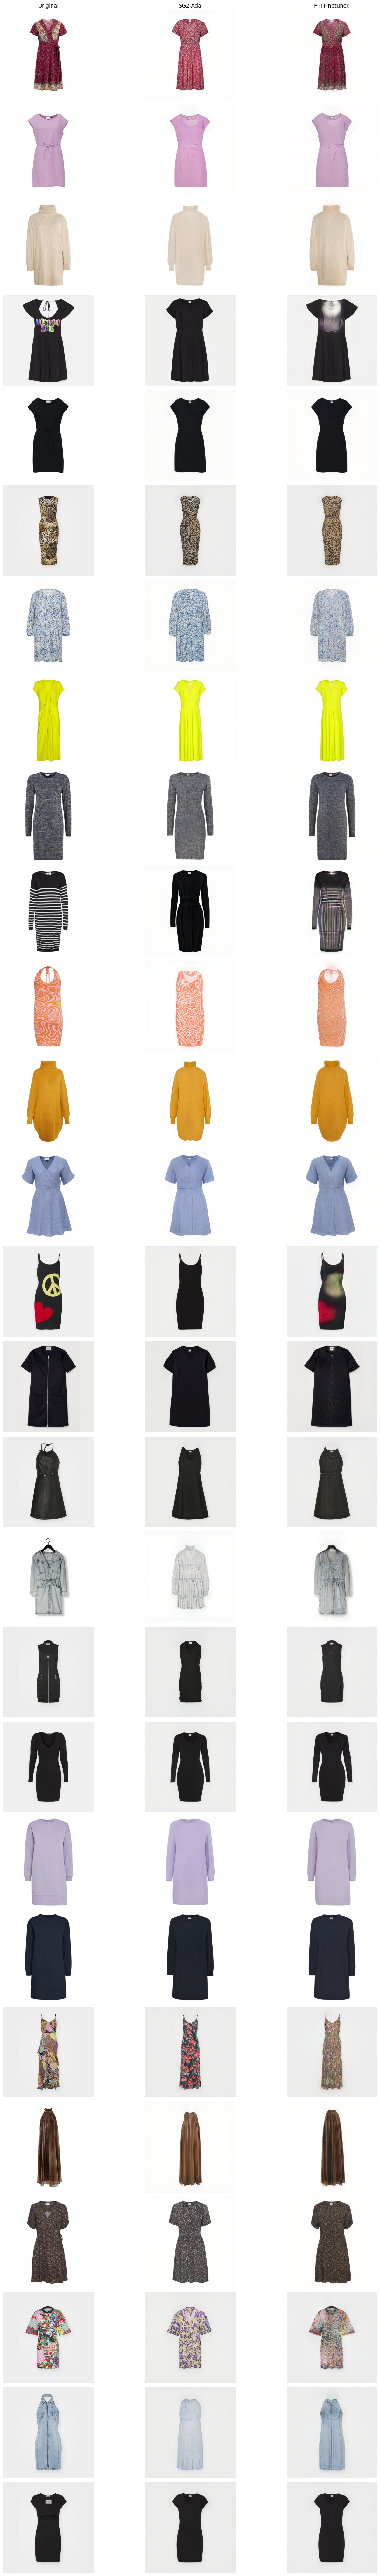

In [8]:
fig, ax = plt.subplots(len(model_paths), 3, figsize = (15, len(model_paths)*3))

for i, path in enumerate(model_paths):
    img_pti, img_sg2 , img_orig = compare_outputs(path)
    ax[i,0].imshow(img_orig)
    ax[i,1].imshow(img_sg2)
    ax[i,2].imshow(img_pti)

    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')

    if i == 0:
        ax[i,0].set_title('Original')
        ax[i,1].set_title('SG2-Ada')
        ax[i,2].set_title('PTI Finetuned')

fig.tight_layout()
plt.show()